In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
import json
import os
import copy
import math
import random
import time

from collections import defaultdict

import numpy as np

## Data load

In [45]:
save_path = '/content/gdrive/MyDrive/Colab Notebooks/Recognitaion_eye_written_char_with_siamese_net/v2_dataset/'

with open(save_path + 'eog_raw_numbers.json') as f:
  eog_raw_numbers = json.load(f)

with open(save_path + 'eog_eb_removed_numbers.json') as f:
  eog_eb_removed_numbers = json.load(f)

with open(save_path + 'eog_katakana.json') as f:
  eog_katakana = json.load(f)

with open(save_path + 'reference_data.json') as f:
  reference_data = json.load(f)


In [46]:
# eog numbers without eye-blink removal

print(eog_raw_numbers.keys())
print(len(eog_raw_numbers['0']))
print(np.array(eog_raw_numbers['0'][0]).shape)
print(np.array(eog_raw_numbers['0'][1]).shape)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
54
(1112, 2)
(1161, 2)


In [47]:
# eog numbers passed eye-blink removal

print(eog_eb_removed_numbers.keys())
print(len(eog_eb_removed_numbers['0']))
print(np.array(eog_eb_removed_numbers['0'][0]).shape)
print(np.array(eog_eb_removed_numbers['0'][1]).shape)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
54
(333, 2)
(343, 2)


In [48]:
# eog katakana

print(eog_katakana.keys())
print(len(eog_katakana['1']))
print(np.array(eog_katakana['1'][0]).shape)
print(np.array(eog_katakana['1'][1]).shape)

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
60
(1250, 2)
(1250, 2)


In [49]:
# reference data

print(reference_data.keys())
print(len(reference_data['katakana']))
print(len(reference_data['numbers']))

print(len(reference_data['katakana']['1'][0]))
print(np.array(reference_data['katakana']['1'][0]).shape)

print(len(reference_data['numbers']['0'][0]))
print(np.array(reference_data['numbers']['0'][0]).shape)


dict_keys(['katakana', 'numbers'])
12
10
1440
(1440, 2)
1440
(1440, 2)


## plot function

In [50]:
# visualization

import matplotlib.pyplot as plt

def plot_images(data_dict):
  classes = list(data_dict.keys())
  n_cls = len(classes)
  n_data = len(data_dict[classes[0]])

  fig, axes = plt.subplots(n_data, n_cls, figsize=(5*n_cls, 5*n_data))

  lim = [-1.1,1.1]
  for i, cls in enumerate(classes):

    if n_data == 1:
      x,y = zip(*data_dict[cls][0])

      axes[i].plot(x,y)
      axes[i].scatter(x,y)

      axes[i].set_xlim(lim)
      axes[i].set_ylim(lim)      

    else:
      for j, idx in enumerate(range(n_data)):
        x,y = zip(*data_dict[cls][idx])

        axes[j][i].plot(x,y)
        axes[j][i].scatter(x,y)

        axes[j][i].set_xlim(lim)
        axes[j][i].set_ylim(lim)      


## preprocessing

In [51]:
# data normalization

def normalization(data_dict, ref=None):
  '''
  일반적인 정규화는 0~1 사이의 값으로 변환하지만,
  본 데이터는 중심점이 (0,0)이 되도록 데이터 내의 모든 값을 -1~1 사이의 값으로 정규화한다.
  '''

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])

    for idx in range(n_data):
      data = dataset[cls][idx]

      max_val = max(np.concatenate(data))
      min_val = min(np.concatenate(data))

      norm_points = []
      for point in data:
        x, y = point

        norm_x = round((x-min_val)/(max_val-min_val), 5)    # min max scaling (0~1 사이 값)
        norm_y = round((y-min_val)/(max_val-min_val), 5)
      
        norm_x = (norm_x - 0.5)*2                           # -0.5~0.5 사이 값 -> -1~1 사이 값
        norm_y = (norm_y - 0.5)*2
      
        norm_points.append([norm_x, norm_y])

      result[cls].append(norm_points)

  return result

In [52]:
# 일반적으로 일정한 주기로 수집된 시계열 데이터들은 sampling 혹은 filtering 과정을 거친다.
# eye written character 는 불필요한 데이터의 집합 자체를 제거해야하기 때문에 filtering과는 다른 방식의 접근이 필요하다.

def noise_removal(data_dict, patch_size, ratio):
  '''
  필요 이상 모여있는 좌표 집합 (closed points set)을 제거한다.
  '''

  def bbox_diag_len(patch):
    # patch에 대한 bounding box의 대각선 길이
    x = np.array(patch)[:,0]
    y = np.array(patch)[:,1]
    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)
    dist =  math.sqrt((max_x-min_x)**2 + (max_y-min_y)**2)
    return round(dist, 4)

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])

    for idx in range(n_data):
      data = dataset[cls][idx]

      treadhold = 0.0
      i = 0
      while True:
        i += 1
        patch_list = []
        patch_diag_list = []

        cutting = len(data)%patch_size
        for p_idx in range(0, len(data), patch_size):     # n개의 points로 이루어진 patch로 분리
          patch = data[p_idx:p_idx+patch_size]
          patch_list.append(patch)
          patch_diag_list.append(bbox_diag_len(patch))         # patch의 대각선 길이 저장
        
        if i == 1:
          diag_avg = np.mean(patch_diag_list)                 # 첫번째 iteration에서 대각선 길이의 평균 값을 기준으로 points의 상태를 구분한다.
          treadhold = float(diag_avg*ratio)

        new_patch_list = []
        for info in zip(patch_list, patch_diag_list):
          patch = np.array(info[0])
          diag = float(info[1])
          if diag < treadhold:
            x = round(np.mean(patch[:,0]), 4)
            y = round(np.mean(patch[:,1]), 4)
            new_patch_list.append([x,y])                  # points가 모여 있다고 판단되면 points의 중앙 값으로 치환
          else:
            new_patch_list.extend(patch.tolist())
        
        if data != new_patch_list:                        # 더이상 변화가 없다면 중지
          data = new_patch_list
        else:
          break

      result[cls].append(data)

  return result


In [53]:
# 일반적인 시계열 데이터는 시간에 대한 특징이 중요하게 작용한다.
# 하지만, eye written character의 경우 시계열 데이터지만, 2차원 공간에 대한 위치적 특성이 중요하기 때문에
# 점과 점 사이의 거리가 일정하도록 유지해야한다.
# 해당 데이터는 좌표의 정보보단 점과 점 사이의 이동 방향과 line이 중요하다.
# v1일 때는 좌표간 거리를 기준으로 계산 했지만, v2에는 point의 수를 기준으로 계산을 수행한다. 

def fill_points(data_dict, n_goal_points, k):
  '''
  전체 데이터 셋에
  데이터의 크기를 입력 데이터의 크기(input shape)로 변환한다.
  데이터의 크기가 목표 보다 클 경우, 그 차이 만큼 무작위 삭제를 한 후, (k * 목표 수)개의 points를 추가하고, 추출한다.
  데이터의 크기가 목표 보다 작을 경우, ( (k+1) * 목표 수 - 데이터의 크기) 만큼 점과 점 사이 points를 추가한 후, 추출한다.
  points의 추가는 한 데이터의 점과 점 사이 거리가 '기준 거리' 보다 작을 경우, 두 점의 중앙에 점을 추가한다.
  여기서, '기준 거리'는 데이터 내의 모든 좌표간 거리의 합을 (k * 목표 수 + 좌표의 수)으로 나눈 값이다. 
  인자로 주어지는 k는 값이 클수록 정교한 결과를 얻을 수 있지만 연산 시간이 증가한다.
  '''

  def get_info(data):
    lines = []
    distances = []
    for i in range(len(data)-1):     # 점과 점에 대한 연결과 거리를 저장
      line = data[i:i+2]
      dist = (abs(line[0][0]-line[1][0])**2+abs(line[0][1]-line[1][1])**2)**(1/2)
      lines.append(line)
      distances.append(dist)
    return lines, distances

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)
  for cls in classes:
    n_data = len(dataset[cls])
    for idx in range(n_data):
      data = dataset[cls][idx]

      if len(data)>n_goal_points:
        data = random.sample(data, n_goal_points)       # 랜덤 제거
        n_add_points = k*n_goal_points                  # 추가할 좌표 수
      else:
        n_add_points = (k+1)*n_goal_points - len(data)

      lines, distances = get_info(data)
      total_dist = sum(distances)
      bench_dist = total_dist / (len(data) + n_add_points)  # 점과 점 사이 기준 거리

      while n_add_points!=0:                                    # 추가해야 할 좌표를 감소 시키면서 반복
        lines, distances = get_info(data)

        new_lines = []
        for i, info in enumerate(zip(lines, distances)):
          line = info[0]
          dist = info[1]
          if dist > bench_dist and n_add_points!=0:                 # 점과 점 사이 거리가 bench_dist보다 클 시 중점을 점과 점 사이에 추가
            line_arr = np.array(line)
            point = [round(sum(line_arr[:,0])/2, 4), 
                     round(sum(line_arr[:,1])/2, 4)]
            line.insert(1, point)
            n_add_points -= 1
          
          if i==0:                                                  # 중복 좌표 제거
            new_lines.extend(line)
          else:
            new_lines.extend(line[1:])
        data = new_lines
      data = data[::k+1]                                       # k번째 항목에 위치한 요소들만 추출해서 goal points 로 축소
      
      result[cls].append(data)
  return result


In [54]:
# 해당 데이터들은 수집 시작 시점과 끝나는 시점에 의미없는 points가 존재하기 때문에
# 끝단의 points를 조정하여 형태를 유지함과 동시에 좌표간 거리를 일정하게 한다.

def dist_equalizer(data_dict, dist_rate):
  '''
  하나의 데이터 내에 존재하는 점과 점사이 거리를 동일하게 조정한다.
  순서가 있는 두 점 사이의 거리가 데이터 내의 모든 distance의 평균이 되도록 두번째 좌표(to_x, to_y)의 위치를 조정한다. 
  '''

  def get_dist_avg(data_dict):
    dist = 0.0
    n = 0
    for cls in classes:
      n_data = len(dataset[cls])
      for idx in range(n_data):
        data = dataset[cls][idx]
        for i in range(len(data)-1):
          line = data[i:i+2]
          dist += (abs(line[0][0]-line[1][0])**2+abs(line[0][1]-line[1][1])**2)**(1/2)
          n += 1
    return dist / n

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  
  dist_avg = get_dist_avg(dataset)*dist_rate

  for cls in classes:
    n_data = len(dataset[cls])
    for idx in range(n_data):
      data = dataset[cls][idx]

      new_data = []
      for i in range(len(data)-1):
        line = data[i:i+2]
        from_x, from_y = line[0]
        to_x, to_y = line[1]
        dist = (abs(from_x - to_x)**2+abs(from_y - to_y)**2)**(1/2)
        
        if from_x < to_x:
          line[1][0] = round(from_x + abs(to_x-from_x)*dist_avg/dist, 4)
        elif from_x > to_x:
          line[1][0] = round(from_x - abs(to_x-from_x)*dist_avg/dist, 4)

        if from_y < to_y:
          line[1][1] = round(from_y + abs(to_y-from_y)*dist_avg/dist, 4)
        elif from_y > to_y:
          line[1][1] = round(from_y - abs(to_y-from_y)*dist_avg/dist, 4)

        if i==0:
          new_data.extend(line)
        else:
          new_data.append(line[-1])

      result[cls].append(new_data)

  return result


In [71]:
input_size = 200

katakana_config = {
    'patch_size':5,
    'ratio':4.0,
    'n_goal_points':input_size,
    'k':2,
    'dist_rate':1.5
}

raw_num_config = {
    'patch_size':3,
    'ratio':1.5,
    'n_goal_points':input_size,
    'k':2,
    'dist_rate':1.0
}

eb_num_config = {
    'patch_size':5,
    'ratio':2.0,
    'n_goal_points':input_size,
    'k':2,
    'dist_rate':1.0
}


In [72]:
# katakana

start = time.time()

norm_katakana = normalization(eog_katakana)
noise_remove_katakana = noise_removal(norm_katakana, katakana_config['patch_size'], katakana_config['ratio'])
filled_katakana = fill_points(noise_remove_katakana, katakana_config['n_goal_points'], katakana_config['k'])
equal_dist_katakana = dist_equalizer(filled_katakana, katakana_config['dist_rate'])

print('runtime :', time.time()-start)

runtime : 51.43057036399841


In [73]:
# arabic numbers without eye-blink remove

start = time.time()

norm_raw_numbers = normalization(eog_raw_numbers)
noise_remove_raw_numbers = noise_removal(norm_raw_numbers, raw_num_config['patch_size'], raw_num_config['ratio'])
filled_raw_numbers = fill_points(noise_remove_raw_numbers, raw_num_config['n_goal_points'], raw_num_config['k'])
equal_dist_raw_numbers = dist_equalizer(filled_raw_numbers, raw_num_config['dist_rate'])

print('runtime :', time.time()-start)

runtime : 22.194353103637695


In [74]:
# arabic numbers with eye-blink remove

start = time.time()

norm_eb_removed_numbers = normalization(eog_eb_removed_numbers)
noise_remove_eb_removed_numbers = noise_removal(norm_eb_removed_numbers, eb_num_config['patch_size'], eb_num_config['ratio'])
filled_eb_removed_numbers = fill_points(noise_remove_eb_removed_numbers, eb_num_config['n_goal_points'], raw_num_config['k'])
equal_dist_eb_removed_numbers = dist_equalizer(filled_eb_removed_numbers, raw_num_config['dist_rate'])

print('runtime :', time.time()-start)

runtime : 17.427112817764282


## reference data

In [59]:
# 참고 데이터는 정규화 된 1440개의 좌표들로 이루어져 있다.
# 1440은 모든 수에 약분이 가능하다.

def sampler(data_dict, input_size):
  '''
  keypoints에 해당하는 좌표를 제외한 좌표들을 목표 수 (input_size)와 동일하게 한다.
  '''

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])

    for idx in range(n_data):
      data = dataset[cls][idx]

      ratio = len(data)/input_size
      patch_size = int(ratio*10)
      indices = [i for i in range(int(ratio), patch_size, int(ratio))]          # patch 내에서 추출할 point 좌표들
      
      new_data = []
      for i in range(0, len(data), patch_size):
        patch = data[i:i+patch_size]
        samples = [patch[i] for i in indices]
        new_data.extend(samples)

      result[cls].append(new_data)
  
  return result


In [60]:
katakana_ref_config = {'input_size':200,
                       'dist_rate':2.0}

numbers_ref_config = {'input_size':200,
                      'dist_rate':1.2}

katakana_ref = reference_data['katakana']
numbers_ref = reference_data['numbers']

In [61]:
# katakana ref

scaled_katakana_ref = sampler(katakana_ref, katakana_ref_config['input_size'])
equal_katakana_ref = dist_equalizer(scaled_katakana_ref, katakana_ref_config['dist_rate'])

In [62]:
# arabic numbers

scaled_numbers_ref = sampler(numbers_ref, numbers_ref_config['input_size'])
equal_numbers_ref = dist_equalizer(scaled_numbers_ref, numbers_ref_config['dist_rate'])

## plot

In [64]:
length = []
for k in equal_dist_eb_removed_numbers.keys():
  for d in range(len(equal_dist_eb_removed_numbers[k])):
    l = np.array(equal_dist_eb_removed_numbers[k][d]).shape
    if l not in length:
      length.append(l)

print(length)

[(200, 2)]


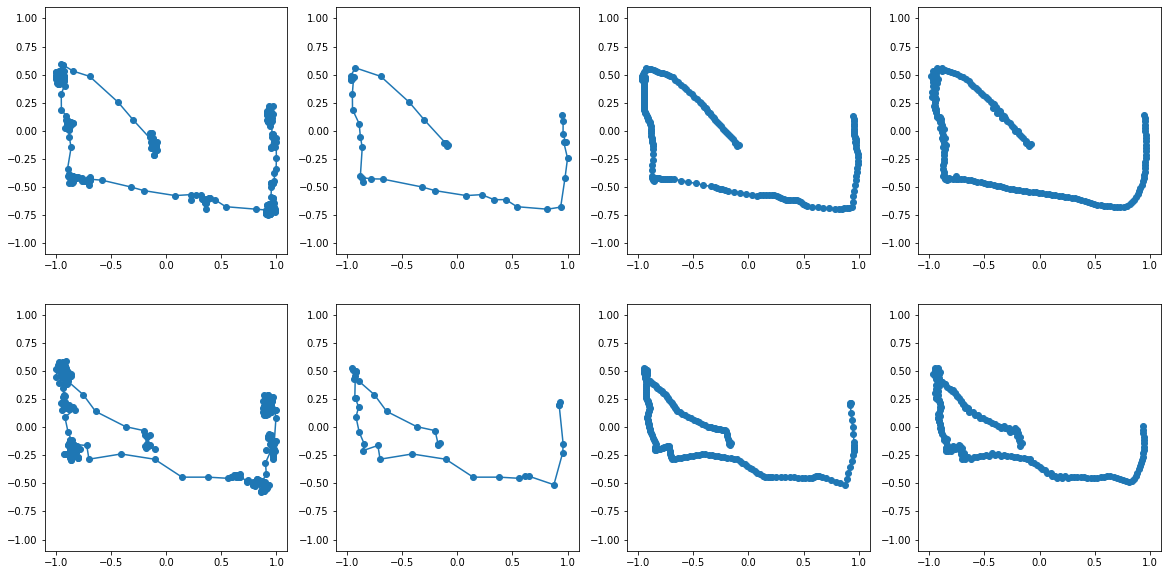

In [77]:
sample = {'1': norm_eb_removed_numbers['0'][:2],
          '2': noise_remove_eb_removed_numbers['0'][:2],
          '3': filled_eb_removed_numbers['0'][:2],
          '4': equal_dist_eb_removed_numbers['0'][:2]}

plot_images(sample)

In [ ]:
plot_images(equal_dist_katakana)

In [ ]:
plot_images(equal_dist_raw_numbers)

In [ ]:
plot_images(equal_dist_eb_removed_numbers)

In [ ]:
plot_images(equal_katakana_ref)

In [ ]:
plot_images(equal_numbers_ref)

## save data

In [70]:
save_path = '/content/gdrive/MyDrive/Colab Notebooks/Recognitaion_eye_written_char_with_siamese_net/v2_dataset/200_points_dataset/'

with open(save_path + 'eog_katakana_200.json','w') as f:
    json.dump(equal_dist_katakana,f)

with open(save_path + 'eog_raw_numbers_200.json','w') as f:
    json.dump(equal_dist_raw_numbers,f)

with open(save_path + 'eog_eb_remove_numbers_200.json','w') as f:
    json.dump(equal_dist_eb_removed_numbers,f)

reference_data = {'katakana': scaled_katakana_ref,
                  'numbers' : scaled_numbers_ref}

with open(save_path + 'reference_data_200.json','w') as f:
    json.dump(reference_data,f)
